# Qoro β-Testing: Warm-up

Good that you finally made it to the notebooks. It is time to do some real coding and experiment with the different features that are offered by our platform.

The goal of this notebook is to walk you through some ready examples implemented in Divi, before we move on to the coding challenges in the next notebook. 

This notebook has two sections, one for the Quantum Chemistry-related features of Qoro, and another for optimization-oriented applications. Feel free to jump through to the one that is relevant the most to you, or go through both to experience the full range of Divi's capabilities.

## Table of Contents
- [Optimization](#optimization-qaoa-and-graph-partitioning-qaoa)
- [Quantum Chemistry](#quantum-chemistry-vqe-and-hyperparameter-grid-search)

## Optimization: QAOA and Graph-Partitioning QAOA

### Single QAOA Problems

If you have been paying attention while reading the docs, you would know that the QAOA class accepts two types of input: 
- A graph (and the corresponding graph problem to be solved), 
- A minimization problem in the form of a QUBO (dense Numpy/Python arrays or sparse SciPy matrices), or Qiskit's `QuantumProgram`s.

You might also remember that you can apply transformations to the circuits, one of which is observable grouping. This transform is particularly useful for optimization problems, where the Hamiltonian is compromised of mainly Pauli-$Z$ terms. As such, through the `qwc` grouping strategy, the whole Hamiltonian can be computed from a single bistring histogram.

The following code sets up an experiment for computing the maximum-clique of a graph, and its QUBO equivalent. This will help you understand the changes in the input arguments, as well the respective output formats.

In [1]:
import dimod
import networkx as nx

from divi.qprog import QAOA, GraphProblem, Optimizers
from divi.parallel_simulator import ParallelSimulator

from divi.qlogger import enable_logging

# This line activates logging for standalone VQE runs.
enable_logging()

In [2]:
def qubo_max_clique(G: nx.Graph):
    """
    Generate a QUBO for the Maximum Clique problem on graph G.
    """

    Q = {}
    nodes = list(G.nodes)

    # Objective: maximize sum x_i => linear terms with negative weight
    for i in nodes:
        Q[(i, i)] = -1.0

    # Penalty for selecting non-connected pairs
    for i in nodes:
        for j in nodes:
            if i < j and not G.has_edge(i, j):
                # Apply the penalty coefficient for non-edges
                Q[(i, j)] = 2

    return dimod.BinaryQuadraticModel.from_qubo(Q)

In [3]:
G = nx.bull_graph()
G_qubo = qubo_max_clique(G)

#### Graph Input

In [4]:
# To check the currently supported graph problems, simply inspect the GraphProblem Enum
list(GraphProblem)

[<GraphProblem.MAX_CLIQUE: ('max_clique', 'Zeros', 'Superposition')>,
 <GraphProblem.MAX_INDEPENDENT_SET: ('max_independent_set', 'Zeros', 'Superposition')>,
 <GraphProblem.MAX_WEIGHT_CYCLE: ('max_weight_cycle', 'Superposition', 'Superposition')>,
 <GraphProblem.MAXCUT: ('maxcut', 'Superposition', 'Superposition')>,
 <GraphProblem.MIN_VERTEX_COVER: ('min_vertex_cover', 'Ones', 'Superposition')>,
 <GraphProblem.EDGE_PARTITIONING: ('', '', '')>]

In [5]:
qaoa_instance = QAOA(
    problem = G,
    graph_problem=GraphProblem.MAX_CLIQUE,
    n_layers=2,
    initial_state="Recommended",
    optimizer=Optimizers.NELDER_MEAD,
    max_iterations=10,
    backend=ParallelSimulator(),
    grouping_strategy="qwc"
)

Let's check how many circuits need to be run to compute the Hamiltonian of the problem.

In [6]:
qaoa_instance.meta_circuits["cost_circuit"].measurement_groups

[[Z(0), Z(1), Z(2), Z(3), Z(4)]]

We have all the terms in a single measurement group. Great!

In [7]:
qaoa_instance.run()

2025-07-16 13:41:27,346 - divi.qprog.quantum_program - INFO - Finished Setup
2025-07-16 13:41:29,526 - divi.qprog.quantum_program - INFO - Finished Iteration #1                                                                                                   
2025-07-16 13:41:29,882 - divi.qprog.quantum_program - INFO - Finished Iteration #2                                                                                                   
2025-07-16 13:41:30,591 - divi.qprog.quantum_program - INFO - Finished Iteration #3                                                                                                   
2025-07-16 13:41:31,209 - divi.qprog.quantum_program - INFO - Finished Iteration #4                                                                                                   
2025-07-16 13:41:31,824 - divi.qprog.quantum_program - INFO - Finished Iteration #5                                                                                                   
2025-07-

(19, 0.0)

After running the optimization loop of a QAOA program, we need to execute one additional circuit, extracting the solution bitstring and converting into our output format.

In [8]:
qaoa_instance.compute_final_solution()

(20, 0.0)

For graph inputs, the solution represents the IDs of the solution nodes. In this case, they represent the nodes in the maximum clique.

In [9]:
qaoa_instance.solution

[0, 1, 2]

And you can even draw the solution!

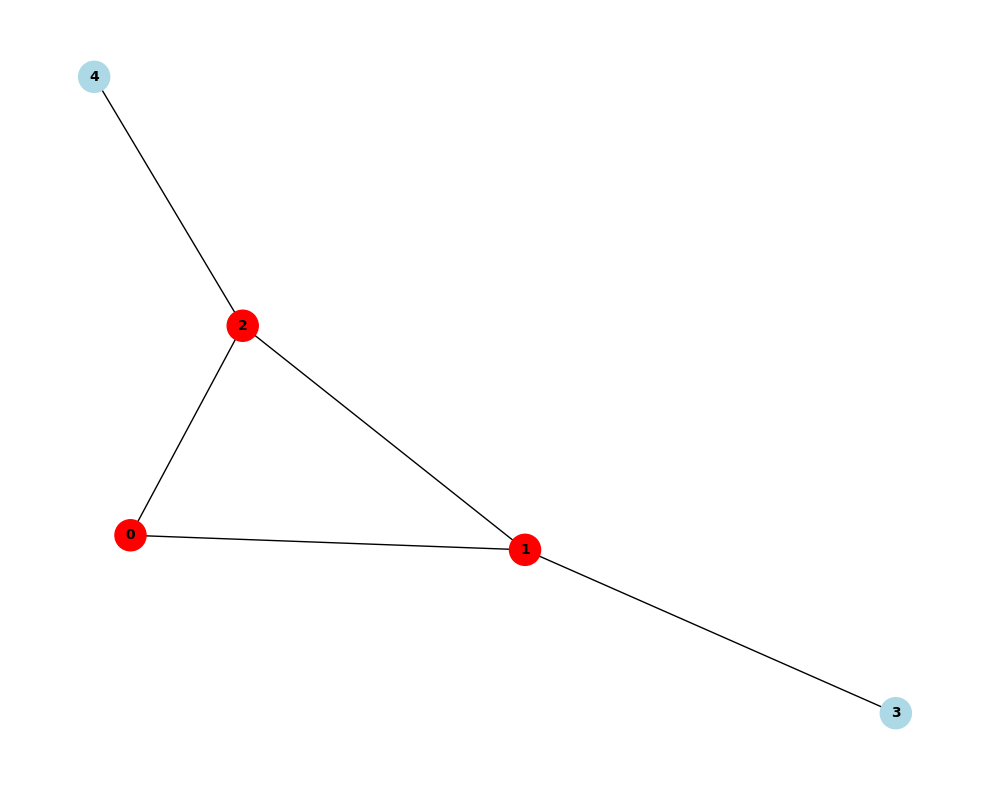

In [10]:
qaoa_instance.draw_solution()

#### QUBO Input

In [11]:
qaoa_instance_qubo = QAOA(
    problem = G_qubo.to_numpy_matrix(),
    n_layers=2, 
    optimizer=Optimizers.NELDER_MEAD,
    max_iterations=20,
    backend=ParallelSimulator(),
    grouping_strategy="wires"
)

/tmp/ipykernel_3668086/2401303299.py:2: DeprecationWarning: bqm.to_numpy_matrix() is deprecated since dimod 0.10.0 and will be removed in 0.12.0
  problem = G_qubo.to_numpy_matrix(),


For QUBO, we get back the most frequently measured bitstring.

In [12]:
qaoa_instance_qubo.run()
qaoa_instance_qubo.compute_final_solution()
qaoa_instance_qubo.solution

2025-07-16 13:41:46,411 - divi.qprog.quantum_program - INFO - Finished Setup
2025-07-16 13:41:50,023 - divi.qprog.quantum_program - INFO - Finished Iteration #1                                                                                                   
2025-07-16 13:41:50,509 - divi.qprog.quantum_program - INFO - Finished Iteration #2                                                                                                   
2025-07-16 13:41:51,059 - divi.qprog.quantum_program - INFO - Finished Iteration #3                                                                                                   
2025-07-16 13:41:51,560 - divi.qprog.quantum_program - INFO - Finished Iteration #4                                                                                                   
2025-07-16 13:41:52,046 - divi.qprog.quantum_program - INFO - Finished Iteration #5                                                                                                   
2025-07-

array([1, 1, 1, 0, 0], dtype=int32)

Indices 0, 1, and 2 are all chosen as part of the solution, which corresponds to the correct solution from before!

### Solving for Big Graphs through Partitioning

Now for the more interesting stuff! What if you are attempting to solve some extra big graph? Maybe one that can't even fit on the hardware you have access to, or maybe one that is painstakingly slow to simulate? This is where our graph-partitioning QAOA class comes in handy.

## Quantum Chemistry: VQE and Hyperparameter Grid Search

### Single VQE Runs

The following code sets up a VQE experiment for determining the ground state energy for a He-H+ ion given some bond length.

In [ ]:
from divi.qprog import VQE, VQEAnsatz
from divi.qprog.optimizers import Optimizers

from divi.parallel_simulator import ParallelSimulator
from divi.qlogger import enable_logging

# This line activates logging for standalone VQE runs.
enable_logging()

In [ ]:
# Check available optimizers
list(Optimizers)

In [ ]:
# Check available ansaetze
list(VQEAnsatz)

In [ ]:
# Set up the molecule parameters, as per Pennylane's format
molecule_symbols = ["He", "H"]
unit_coordinates = [(1.0, 0.0, 0.0), (-2.0, 0.0, 0.0)]
charge = 1

In [ ]:
# Let's experiment with some arbitrary bond length for now
experiment_bond_length = 2.4

In [ ]:
local_sim = ParallelSimulator(shots=5000)

In [ ]:
# Create the VQE instance
vqe_instance = VQE(
    # Molecule parameters
    symbols=molecule_symbols, 
    coordinate_structure=unit_coordinates,
    bond_length=experiment_bond_length,
    charge=charge,
    # Circuit parameters
    ansatz=VQEAnsatz.UCCSD,
    n_layers=2,
    # Optimizer parameters
    optimizer=Optimizers.NELDER_MEAD,
    max_iterations=10,
    # Backend
    backend=local_sim,
    # Parameter initialization seed
    seed=31923
)

Now, let's inspect the `VQE` object a bit, and see what is going on behind the scenes.

In [ ]:
# Let's check how many qubits are needed to represent the molecule's dynamics
vqe_instance.n_qubits

In [ ]:
# We see that we have a single meta (or template) circuit.
# This is because the structure of the circuit won't change, only its parameters
print(vqe_instance.meta_circuits)

In [ ]:
# If we inspect the variable measurement_groups, we can see all the hamiltonian term groups
# that need to be measured for a single computation of the Hamiltonian (26 in this case)
vqe_instance.meta_circuits["cost_circuit"].measurement_groups

Okay, let's lauch the optimization and see what we get.

In [ ]:
n_executed_circuits, _ = vqe_instance.run()

Looks like 598 circuit executions were executed in total for the optimization round. Let's check the final loss values. Since we are using Nelder-Mead, we only have a single loss value per loss set. For optimizers like Monte-Carlo, you will have multiple loss values coming from every sampled parameter values.

In [ ]:
vqe_instance.losses[-1]

We can worry about this loss value later. For now, let's try to bring down the number of executed circuits. This can be achieved through observable grouping (mentioned in the _Circuit Transformations_ page of the docs). Let's see how much reduction we get for each grouping strategy. 

In [ ]:
# This is a little hack to re-generate the meta circuits without instantiating a whole new object 
vqe_instance._meta_circuit_factory.keywords["grouping_strategy"] = "wires"
vqe_instance._meta_circuits = vqe_instance._create_meta_circuits_dict()
len(vqe_instance.meta_circuits["cost_circuit"].measurement_groups)

In [ ]:
n_executed_circuits_wires, _ = vqe_instance.run()

n_executed_circuits_wires - n_executed_circuits

Those are some nice savings! At least 200 fewer circuits executed. Let's see if this impacted the final loss.

In [ ]:
vqe_instance.losses[-1]

It didn't change much, which makes sense, since grouping only affects the post-processing of the obsevations, not the actual circuit structure.

### VQE Hyperparameter Sweeps ("Grid Search")

Now, we ran a VQE experiment for a single bond length, for a single type of ansatz, but what if we want to test out several to see which one has the lowest energy? This is where the hyperparameter sweep class comes in handy.

Since running that many jobs in parallel might be taxing on the local simulator, we will also switch to the cloud backend in this section, so **have your API key ready**!

Note how we only need to change very little to carry on the parameters from the single VQE experiment to a sweep.

In [ ]:
from divi import QoroService
from divi.qprog import VQEHyperparameterSweep
import numpy as np

In [ ]:
qoro_service = QoroService(auth_token="YOUR_API_KEY_HERE", shots=5000)

In [ ]:
bond_lengths_range = list(np.linspace(0.1, 3.0, 5))

In [ ]:
# Create the VQE instance
vqe_sweep_instance = VQEHyperparameterSweep(
    # Molecule parameters
    symbols=molecule_symbols, 
    coordinate_structure=unit_coordinates,
    bond_lengths=bond_lengths_range, # CHANGED
    charge=charge,
    # Circuit parameters
    ansatze=[VQEAnsatz.UCCSD], # CHANGED
    n_layers=2,
    # Optimizer parameters
    optimizer=Optimizers.NELDER_MEAD,
    max_iterations=10,
    # Backend
    backend=qoro_service,
    # Parameter initialization seed
    seed=31923
)

In [ ]:
vqe_sweep_instance.create_programs()

vqe_sweep_instance.programs # We should expect to see 5 programs, one for each bond length

By running the next cell, all the jobs will begin executing.

You can track the progress of each job with the help of the rendered progress bars. Note that Jupyter might indicate that the cell has finished executing right away, but this is a bug since Jupyter does not play well with our code, so only rely on the rendered progress bars to determine whether all jobs are done.

In [ ]:
vqe_sweep_instance.run()

In [ ]:
(best_ansatz, best_bond_length), lowest_energy = vqe_sweep_instance.aggregate_results()

print(f"Bond length corresponding to lowest energy: {best_bond_length}")
print(f"Lowest energy achieved: {round(lowest_energy, 5)}")

In [ ]:
vqe_sweep_instance.visualize_results()

We can go the extra mile and extract the losses from every job during with optimization.

In [ ]:
import matplotlib.pyplot as plt

x = list(range(10))

for program in vqe_sweep_instance.programs.values():
    curr_losses = [loss[0] for loss in program.losses]
    plt.plot(x, curr_losses, label=f"{program.bond_length:.3f}")

plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.legend(title="Bond Length")
plt.title("Optimization Losses")
plt.show()